<a href="https://colab.research.google.com/github/arielwendichansky/DI_Bootcamp/blob/master/Week7/Day5/Exercise_XP/Exercise_XP_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import stats, cluster
from scipy.optimize import minimize_scalar
from scipy.stats import skew, kurtosis, median_test,ttest_ind, norm
from plotnine import (ggplot,aes,geom_line,facet_wrap,labs, scale_x_datetime, element_text, theme_538)
from plotnine.data import meat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, recall_score


# Extract info Kaggle

In [ ]:
! pip install -k kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d iammustafatz/diabetes-prediction-dataset

In [ ]:
! unzip 'diabetes-prediction-dataset.zip'

In [ ]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

# Initial Data Exploration

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.885856,22.516840,0.08,24.00,43.00,60.00,80.00
hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.527507,1.070672,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.058060,40.708136,80.00,100.00,140.00,159.00,300.00
diabetes,100000.0,0.085000,0.278883,0.00,0.00,0.00,0.00,1.00


# Data cleaning

In [ ]:
# I left only the data with gender Male or Female as for the 'other' we only have 18 rows
df = df.drop(df[df['gender'] == 'Other'].index)

# Data integrity

In [ ]:
cdata = df.copy()

In [ ]:
# For smoker column correcting them to only 3 column
cdata = cdata.replace({'No Info': 'never', 'not current': 'current', 'ever': 'current'})

In [ ]:
# Correcting values where a person with age lower than 14 can be smoker.
cdata.loc[cdata['age'] < 14, 'smoking_history'] = cdata.loc[cdata['age'] < 14, 'smoking_history'].replace({'No Info': 'never', 'former': 'never', 'current': 'never'})


In [ ]:
cdata['smoking_history'].value_counts()

smoking_history
never      71284
current    19348
former      9350
Name: count, dtype: int64

# Analysis

In [ ]:
positive_case = df[df['diabetes']==1].count()
negative_case = df[df['diabetes']==0].count()

class_names = {0:'Negative', 1:'Positive'}
print(df['diabetes'].value_counts().rename(index = class_names))

diabetes
Negative    91482
Positive     8500
Name: count, dtype: int64


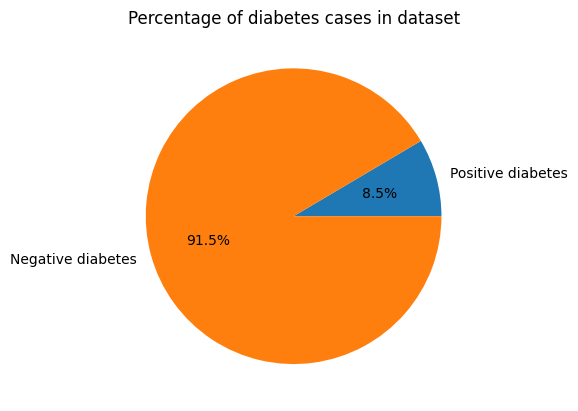

In [ ]:
labels = 'Positive diabetes', 'Negative diabetes'
fig, ax = plt.subplots()
ax.pie([positive_case['diabetes'],negative_case['diabetes']], labels=labels, autopct='%1.1f%%')
plt.title('Percentage of diabetes cases in dataset')
plt.show()


In [ ]:
# I need to determine the number of bins to divide the data, based on the nunmber of rows I have.
# I used Sturges' Formula.

k = int(1 + math.log2(len(cdata)))
print("Number of bins according to Sturges' Formula:", k)

# I have 17 bins and the difference between each will be:

bins_range = int((cdata['age'].max()/k).round())
print("Range of bins :",bins_range)

# Creating a list for each bin
bin_boundaries = []
for i in range(k):
    bin_start = 0 + i * 5
    bin_end = bin_start + 5 - 1
    bin_boundaries.append((bin_start, bin_end))

print(bin_boundaries)


Number of bins according to Sturges' Formula: 17
Range of bins : 5
[(0, 4), (5, 9), (10, 14), (15, 19), (20, 24), (25, 29), (30, 34), (35, 39), (40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74), (75, 79), (80, 84)]


In [ ]:
ndf = df.copy()

# Extract bin boundaries as a list of integers, because can't plot it as tupple
bins = [bin_start for bin_start, _ in bin_boundaries]

# Create bins based on the predefined bin boundaries
ndf['Bin'] = pd.cut(ndf['age'], bins=bins)

#Sorting values
ndf_sort = ndf.sort_values(by='Bin')

# Convert the 'Bin' column to string for plotting
ndf_sort['Bin'] = ndf_sort['Bin'].astype(str)


# Plot the histogram
fig = px.histogram(ndf_sort, x='Bin', title='Age Distribution', color='gender', labels={'Bin': 'Ages', 'count': 'Frequency'})

# Show the plot
fig.show()

In [ ]:
# Map values in the 'diabetes' column to their corresponding labels
ndf_sort['diabetes'] = ndf_sort['diabetes'].map({0: 'Negative', 1: 'Positive'})

# Plot the histogram
fig = px.histogram(ndf_sort, x='diabetes', title='Diabetes cases by gender', color='gender', labels={'diabetes': 'Diabetes case', 'count': 'Frequency'})

# Show the plot
fig.show()


In [ ]:
ndf_sort.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,Bin
73129,Female,4.00,0,0,No Info,16.69,3.5,80,Negative,"(0, 5]"
28813,Male,5.00,0,0,not current,15.51,3.5,140,Negative,"(0, 5]"
11630,Female,0.80,0,0,No Info,27.32,3.5,126,Negative,"(0, 5]"
82582,Female,1.24,0,0,No Info,16.50,4.8,158,Negative,"(0, 5]"
15758,Male,2.00,0,0,No Info,15.19,5.0,159,Negative,"(0, 5]"


In [ ]:
percentage_male_diabetes = (ndf_sort[(ndf_sort['gender'] == 'Male') & (ndf_sort['diabetes'] == 'Positive')].count() / ndf_sort[ndf_sort['gender'] == 'Male'].count())*100

percentage_female_diabetes = (ndf_sort[(ndf_sort['gender'] == 'Female') & (ndf_sort['diabetes'] == 'Positive')].count() / ndf_sort[ndf_sort['gender'] == 'Female'].count())*100
# Extract the resulting percentage value
percentage_male_diabetes_total = percentage_male_diabetes.values[0]
percentage_female_diabetes_total = percentage_female_diabetes.values[0]

print("Number of males in dataset:", ndf_sort[ndf_sort['gender'] == 'Male'].count().values[0])
print("Percentage of males with diabetes: %", percentage_male_diabetes_total.round(2))

print("Number of females in dataset:", ndf_sort[ndf_sort['gender'] == 'Female'].count().values[0])
print("Percentage of females with diabetes: %", percentage_female_diabetes_total.round(2))


Number of males in dataset: 41430
Percentage of males with diabetes: % 9.75
Number of females in dataset: 58552
Percentage of females with diabetes: % 7.62


Based on the data provided in the dataset, there's a 9.75% probability of being a man with diabetes among 41,430 cases, and a 7.62% probability of being a woman with diabetes among 58,552 cases.

In [ ]:
ndf_sort = ndf_sort.replace({'No Info': 'never', 'not current': 'current', 'ever': 'current'})
ndf_sort.loc[ndf_sort['age'] < 14, 'smoking_history'] = ndf_sort.loc[ndf_sort['age'] < 14, 'smoking_history'].replace({'No Info': 'never', 'former': 'never', 'current': 'never'})

# Plot the histogram
fig = px.histogram(ndf_sort, x='Bin', title='Age Smoking Distribution', color='smoking_history', labels={'Bin': 'Ages', 'count': 'Frequency'})

# Show the plot
fig.show()

After the age  of 15 is it possible to notice an increase in the current smokers.

# Regression model

Splitting the data into training and testing data

In [ ]:
# Encoding string values to numeric values
cdata = pd.get_dummies(cdata, columns = ['gender', 'smoking_history'])


In [ ]:
# Changing the columns order so we can use the diabetes one as the target column
desired_order = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
                 'blood_glucose_level', 'gender_Female', 'gender_Male',
                 'smoking_history_current', 'smoking_history_former',
                 'smoking_history_never', 'diabetes']

cdata = cdata[desired_order]

In [ ]:
feature_start = 0
feature_end = 11  # Assuming 8 is the last column index for features
target_index = 11


feature_names = cdata.iloc[:, feature_start:feature_end].columns
target = cdata.iloc[:, target_index ].name
print(feature_names)
print(target)


data_features = cdata[feature_names]
data_target = cdata[target]

X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, train_size=0.80, test_size=0.20, random_state=1)
print("Length of X_train is: {X_train}".format(X_train = len(X_train)))
print("Length of X_test is: {X_test}".format(X_test = len(X_test)))
print("Length of y_train is: {y_train}".format(y_train = len(y_train)))
print("Length of y_test is: {y_test}".format(y_test = len(y_test)))

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'gender_Female', 'gender_Male',
       'smoking_history_current', 'smoking_history_former',
       'smoking_history_never'],
      dtype='object')
diabetes
Length of X_train is: 79985
Length of X_test is: 19997
Length of y_train is: 79985
Length of y_test is: 19997


We are going to use the regresion model for the following problem, as we want to predict if based on the different labels will the person will have diabetes or not.

The data will be classified as positive diabetes or negative diabetes.

# Exercise 3 : Model Training

In [ ]:
# # We needed to standarize our dataset, otherwise it wouldn't allow us to iterate over all the data
scaler = StandardScaler() # From Sklearn we imported StandardScaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(solver='sag', max_iter=2000)

# Training the logistic regression model

# we use .ravel() to transform the y_train data into a 1D array because LogisticRegression()
# expects the target variable (in this case, y_train) to be a 1D array rather than a column vector or a 2D array.
model.fit(X_train_scaled, y_train.values.ravel())



LogisticRegression(max_iter=2000, solver='sag')

In [ ]:
# Measuring the accuracy from the model
train_accuracy = model.score(X_train_scaled, y_train)
test_accuracy = model.score(X_test_scaled, y_test)


print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.960055010314434
Test Accuracy: 0.9603440516077412


It can be seen that the accuracy of our model is high with a 96% of accuracy

[0 0 0 ... 0 0 0]


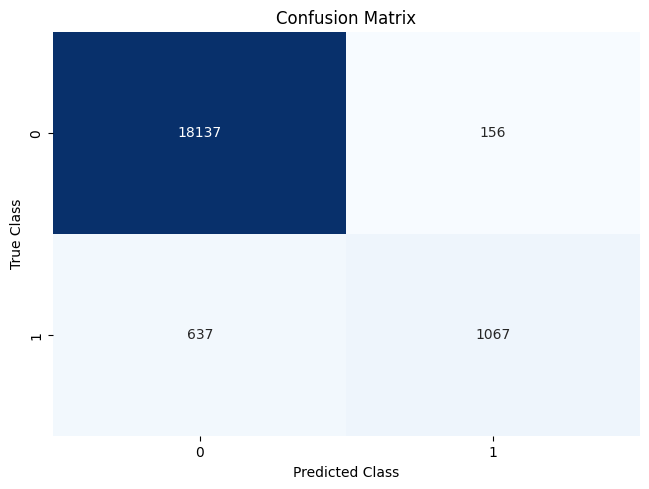

In [ ]:
# Generate predictions using the trained model
pred = model.predict(X_test_scaled)

# Now calculate the confusion matrix using y_test and pred
matrix = confusion_matrix(y_test, pred)

# Create pandas dataframe
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt='g')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()


Based on this result we can assume that our model has high accuracy in predicting if a patient has or not have diabetes based on their data.

True Negative (Top-Left): 18.137 non-diabetic patients where correctly diagnostified.

False Negative (Bottom-Left): 637 non-diabetic patients where were incorrectly predicted  (Type II error).

False Positive (Top-Right): 156 diabetic patients were incorrectly identified as non-diabetic.
True Positive (Top-Right): 1067 diabetic patients were correctly identified  (Type I error).

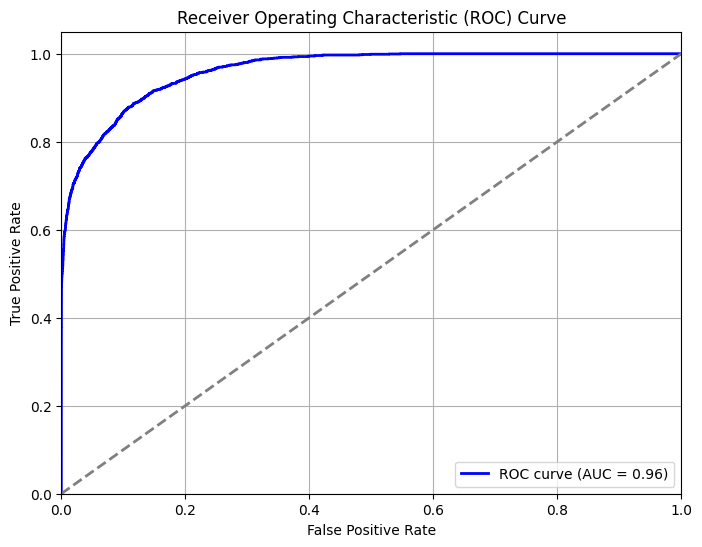

In [ ]:

# Calculate the probabilities of the positive class
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the area under the ROC curve (AUC)
roc_auc = roc_auc_score(y_test, y_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


As the ROC value is 0.96 it's possible to see the high model accuracy distinguishing the two classes, the True Positive Rate (Sensitivity) against the False Positive Rate (1 - Specificity).